In [1]:
import neuron
from neuron import h
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
%matplotlib inline

h.load_file('stdrun.hoc')
mechanisms_dir = '../components/mechanisms'
templates_file = '../components/templates/templates.hoc'
neuron.load_mechanisms(mechanisms_dir)
h.load_file(templates_file) # reads in template

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.steps_per_ms = 1 / h.dt
h.celsius = 36.0

### Setup

In [2]:
tstart = 500. # ms
tdur = (1000., 2000.) # ms. single event duration, baseline firing duration
vclamp_amp = -60. # mV
delay = 1. # ms

cell_fr = {'CP': 1.9, 'CS': 1.3, 'FSI': 7.5, 'LTS': 5.0} # baseline firing rate Hz.
cell_hnames = {c: c + '_Cell' for c in cell_fr}
cell_fr.update({'Thal': 1., 'Base': 1.})

common_settings = {"threshold": 0.0, "weight": 1.0}
background_settings = {
    'Thal2CP': {'sec_id': 2, 'sec_x': 0.8, **common_settings},
    'Thal2CS': {'sec_id': 2, 'sec_x': 0.8, **common_settings},
    'Base2FSI': {'sec_id': 1, 'sec_x': 0.5, **common_settings},
    'Base2LTS': {'sec_id': 1, 'sec_x': 0.5, **common_settings},
}

with open('connection_settings.json', 'r') as f:
    conn_type_settings = json.load(f)
conn_type_settings.update(background_settings)

folder = 'synaptic_models'
syn_params = {}
for conn, setting in conn_type_settings.items():
    with open(os.path.join(folder, conn + '.json'), 'r') as f:
        syn_params[conn] = json.load(f)
    setting['pre_cell'], setting['post_cell'] = conn.split('2')

In [3]:
h.tstop = tstop = tstart + tdur[0] + tdur[1] # how long to run the simulation in ms
cells = {c: getattr(h, n)() for c, n in cell_hnames.items()}

sstim = h.NetStim() # single event
sstim.start = tstart
sstim.interval = tdur[0]
sstim.number = 1

pre_stim = {} # baseline firing
vcls = {} # vclamps
vcldur = [tstart, tstop, 1e9]
for c, fr in cell_fr.items():
    ns = h.NetStim()
    ns.start = tstart + tdur[0]
    ns.interval = 1000 / fr
    ns.number = int(tdur[1] * fr / 1000) + 1
    pre_stim[c] = ns
    if c in cells:
        vcls[c] = vcl = h.VClamp(cells[c].soma[0](0.5))
        for i in range(3):
            vcl.dur[i] = vcldur[i]
            vcl.amp[i] = vclamp_amp

syns = {} # synapses
scs = {} # single cell connections
ncs = {} # network connections
for conn, setting in conn_type_settings.items():
    cell = cells[setting['post_cell']]
    syn_param = syn_params[conn].copy()
    syn_type = syn_param.pop('level_of_detail')
    syns[conn] = syn = getattr(h, syn_type)(list(cell.all)[setting['sec_id']](setting['sec_x']))
    for key, value in syn_param.items():
        setattr(syn, key, value)
    scs[conn] = h.NetCon(sstim, syn, setting['threshold'], delay, setting['weight'])
    ncs[conn] = h.NetCon(pre_stim[setting['pre_cell']], syn, setting['threshold'], delay, setting['weight'])

# record data
t = h.Vector() # Vectors are used to record data in the simulation
t.record(h._ref_t)
soma_v = {}
for c, cell in cells.items():
    soma_v[c] = h.Vector()
    soma_v[c].record(cell.soma[0](0.5)._ref_v)
isyns = {}
Prs = {}
for conn, syn in syns.items():
    isyns[conn] = h.Vector()
    isyns[conn].record(syn._ref_i)
    Prs[conn] = h.Vector()
    Prs[conn].record(syn._ref_Pr)


### Simulation

In [4]:
h.run()

0.0

### Results

Maximum current amplitude in CP: 8.26e-05 mV
Maximum current amplitude in CS: 5.07e-05 mV
Maximum current amplitude in FSI: 4.4e-06 mV
Maximum current amplitude in LTS: 7.34e-05 mV


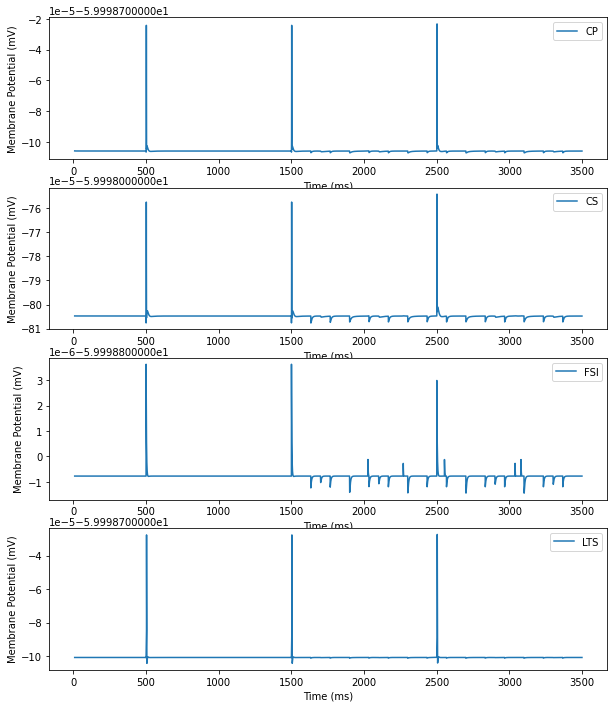

In [5]:
skip = int(10 / h.dt) # ms
tt = np.array(t)
_, axs = plt.subplots(len(cells), 1, figsize=(10, 3 * len(cells)))
for ax, c in zip(axs, cells):
    v = np.array(soma_v[c])[skip:]
    ax.plot(tt[skip:], v, label=c)
    ax.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Membrane Potential (mV)')
    print(f'Maximum current amplitude in {c}: {np.max(v - v.mean()):.3g} mV')
plt.show()

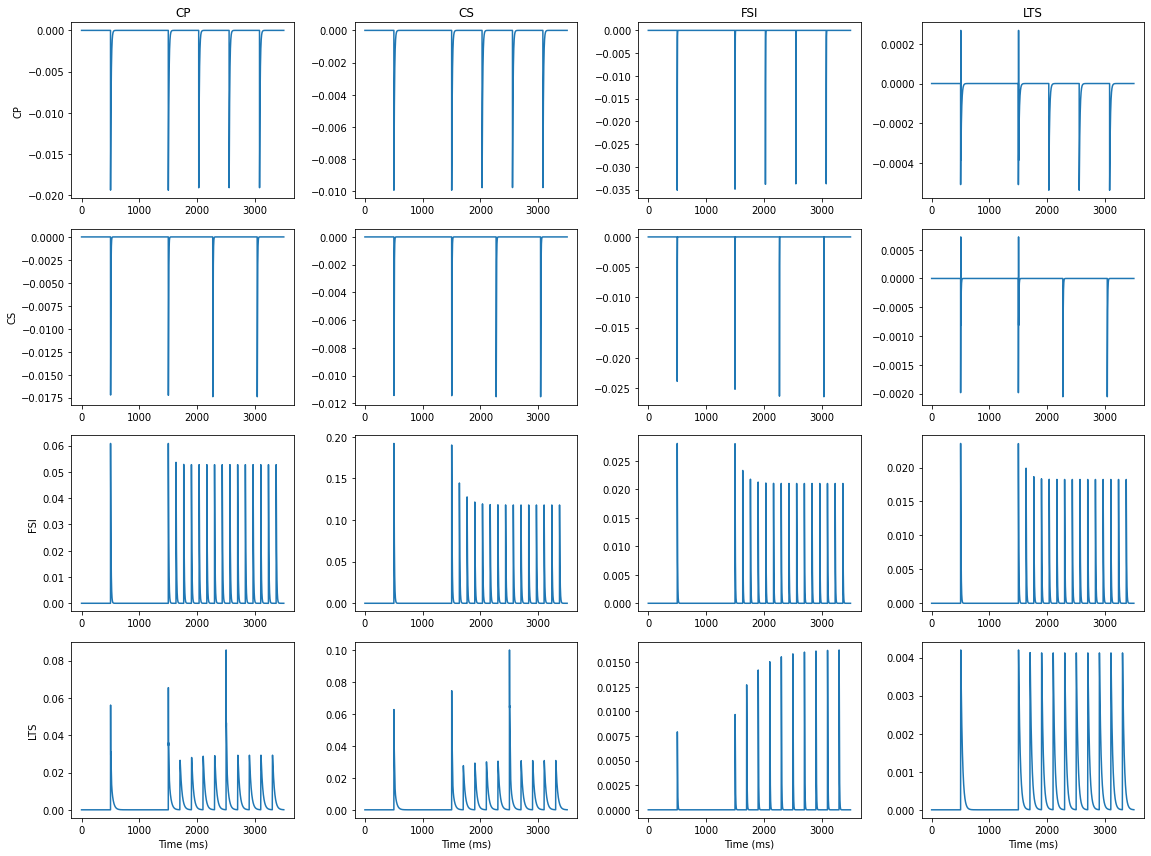

In [6]:
cell_id = {c: i for i, c in enumerate(cells)}
cell_id.update({'Thal': -1, 'Base': -1})

_, axs = plt.subplots(len(cells), len(cells), figsize=(4 * len(cells), 3 * len(cells)))
for conn, setting in conn_type_settings.items():
    pre, post = setting['pre_cell'], setting['post_cell']
    i, j = cell_id[pre], cell_id[post]
    if i < 0:
        continue
    ax = axs[i, j]
    ax.plot(t, isyns[conn])
    if j == 0:
        ax.set_ylabel(pre)
    if i == 0:
        ax.set_title(post)
    if i == len(cells) - 1:
        ax.set_xlabel('Time (ms)')
plt.tight_layout()

# _, axs = plt.subplots(len(cells), len(cells), figsize=(4 * len(cells), 3 * len(cells)))
# for conn, setting in conn_type_settings.items():
#     pre, post = setting['pre_cell'], setting['post_cell']
#     i, j = cell_id[pre], cell_id[post]
#     if i < 0:
#         continue
#     ax = axs[i, j]
#     ax.plot(t, Prs[conn])
#     if j == 0:
#         ax.set_ylabel(pre)
#     if i == 0:
#         ax.set_title(post)
#     if i == len(cells) - 1:
#         ax.set_xlabel('Time (ms)')
# plt.tight_layout()

plt.show()

### Calculate integrated synaptic current and convergence current

In [7]:
convergence = np.array([  # convergence matrix
    [127.6, 8.0, 98.9, 129.3],
    [71.5, 47.2, 121.3, 144.2],
    [45.0, 39.7, 79.0, 22.4],
    [42.2, 10.4, 35.6, 12.2],
    [1., 1., 1., 1.]  # from background
])

t_idx = (tt > tstart) & (tt < tstart + tdur[0])
t0 = int((tstart + tdur[0]) / h.dt)
t1 = int((tstart + tdur[0] + tdur[1]) / h.dt)
I_int = {}
n_conv = {}
for conn, setting in conn_type_settings.items():
    Pr = np.array(Prs[conn])
    I_int[conn] = Pr[t1] / Pr[t0] * np.trapz(np.array(isyns[conn])[t_idx], tt[t_idx])
    pre, post = setting['pre_cell'], setting['post_cell']
    n_conv[conn] = convergence[cell_id[pre], cell_id[post]]

In [8]:
df = pd.DataFrame.from_dict({'I_integrate': I_int, 'n_convergence': n_conv}).rename_axis(index='connection')
df['I_conv'] = df['I_integrate'] * df['n_convergence']
df.to_csv('integrated_synaptic_current.csv')
df

,I_integrate,n_convergence,I_conv
connection,,,
CP2CP,-0.203939,127.6,-26.022595
CP2CS,-0.104856,8.0,-0.838848
CS2CS,-0.070528,47.2,-3.328928
CS2CP,-0.110239,71.5,-7.882072
CP2FSI,-0.061198,98.9,-6.052502
CS2FSI,-0.031165,121.3,-3.780333
CP2LTS,-0.006374,129.3,-0.824216
CS2LTS,-0.008743,144.2,-1.260759
FSI2CP,0.437080,45.0,19.668586


### Adjust synaptic weights

In [9]:
df_M1 = pd.read_csv('integrated_synaptic_current_M1.csv', index_col='connection')

folder = 'synaptic_models'
syn_params = {}
for conn in conn_type_settings:
    with open(os.path.join(folder, conn + '.json'), 'r') as f:
        syn_params[conn] = json.load(f)

for conn, syn_param in syn_params.items():
    initW = syn_param['initW']
    syn_param['initW'] = initW * df_M1.loc[conn, 'I_conv'] / df.loc[conn, 'I_conv']
    print(f'{conn:7s}: {initW:7.4g}   -> {syn_param["initW"]:7.4g}')

CP2CP  :    0.78   ->   1.787
CP2CS  :    0.42   ->   3.131
CS2CS  :    0.52   ->   2.835
CS2CP  :     1.6   ->   5.891
CP2FSI :     1.9   ->    7.56
CS2FSI :       1   ->   5.509
CP2LTS :    0.08   ->  0.4758
CS2LTS :    0.85   ->   2.402
FSI2CP :     3.9   ->  0.9442
FSI2CS :      16   ->   1.844
LTS2CP :    1.75   ->  0.3794
LTS2CS :     2.3   ->  0.6274
FSI2FSI:     5.5   ->   2.079
FSI2LTS:    3.65   ->   5.211
LTS2FSI:     2.4   ->   2.388
LTS2LTS:     0.8   ->   2.154
Thal2CP:    13.5   ->   11.68
Thal2CS:    21.3   ->   21.08
Base2FSI:    3.38   ->   3.307
Base2LTS:    4.45   ->   4.266


In [10]:
# Overwrite synaptic parameter json files
folder = "synapses_scaled_M1"
for conn, syn_param in syn_params.items():
    syn_param['initW'] = float(format(syn_param['initW'], '.2g'))
    with open(os.path.join(folder, conn + '.json'), 'w') as f:
        json.dump(syn_param, f, indent=4)